In [1]:
%load_ext autoreload
%autoreload 2
import os, argparse, random, math, sys, pickle, scipy
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import bootstrap
plt.rcParams["font.family"] = "Serif"
sys.path.append("..")
from data.ihdp import generate_ihdp_nc

In [ ]:
def get_full_eval_df(num_reps, checkpoint_dir, model): 
    eval_df = []
    for rep in range(num_reps):
        curr_cp_dir = os.path.join(checkpoint_dir, f"rep={rep}", model)
        curr_eval_path = os.path.join(curr_cp_dir, f"eval.csv")
        assert os.path.isfile(curr_eval_path), curr_eval_path
        curr_eval_df = pd.read_csv(curr_eval_path)
        curr_eval_df["rep"] = rep
        eval_df.append(curr_eval_df)
    eval_df = pd.concat(eval_df)
    return eval_df    
map_dict = {"sbd-tlearner": "SBD (T-learner)", "cfd-tlearner": "CFD (T-learner)", "lobster": "CFD (LobsterNet)"}

In [4]:
num_reps=20
nc_types = ["one-sided", "two-sided"]
os_nc_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ts_nc_rates = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] + [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
model_strs = ["sbd-tlearner", "cfd-tlearner", "lobster"]

In [5]:
rdata_path = os.path.join("../../data", "IHDP", "ihdp.RData") # source: https://github.com/vdorie/npci
assert os.path.isfile(rdata_path)
delta_A_df = {"nc_type": [], "nc_rate": [], "rep": [], "delta_A": []}
for nc_type in nc_types:
    if nc_type == "one-sided":
        nc_rates = os_nc_rates
    elif nc_type == "two-sided":
        nc_rates = ts_nc_rates
    for nc_rate in tqdm(nc_rates): 
        for rep in range(num_reps):
            train_df, test_df = generate_ihdp_nc(rdata_path, rep=rep, size=4.0,
                  non_compliance_type=nc_type, rate=nc_rate)
            delta_A = np.abs(np.mean(test_df["A_T1"] - test_df["A_T0"]))
            delta_A_df["nc_type"].append(nc_type)
            delta_A_df["nc_rate"].append(nc_rate)
            delta_A_df["rep"].append(rep)
            delta_A_df["delta_A"].append(delta_A)
delta_A_df = pd.DataFrame(delta_A_df)
delta_A_df = delta_A_df.drop(columns=["rep"]).groupby(["nc_type", "nc_rate"]).mean().reset_index()

100%|██████████| 18/18 [00:07<00:00,  2.56it/s]


In [6]:
# load IHDP eval results
eval_df_list = []
for nc_type in nc_types:
    if nc_type == "one-sided":
        nc_rates = os_nc_rates
    elif nc_type == "two-sided":
        nc_rates = ts_nc_rates
    for nc_rate in tqdm(nc_rates): 
        for model in model_strs:
            ihdp_setting = f"type={nc_type}/rate={nc_rate}_size=4.0"
            ihdp_mod_checkpoint_dir = os.path.join("..", "..", "checkpoints", f"IHDP-rate/{ihdp_setting}")
            assert os.path.isdir(ihdp_mod_checkpoint_dir)
            ihdp_mod_eval_df = get_full_eval_df(num_reps, ihdp_mod_checkpoint_dir, model)
            ihdp_mod_eval_df["nc_type"] = nc_type
            ihdp_mod_eval_df["nc_rate"] = nc_rate
            ihdp_mod_eval_df["model"] = model
            eval_df_list.append(ihdp_mod_eval_df)
ihdp_rate_eval_df = pd.concat(eval_df_list)
ihdp_rate_eval_df.model = ihdp_rate_eval_df.model.map(map_dict)
ihdp_rate_eval_df = ihdp_rate_eval_df.merge(delta_A_df, on=["nc_type", "nc_rate"], how="left")

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


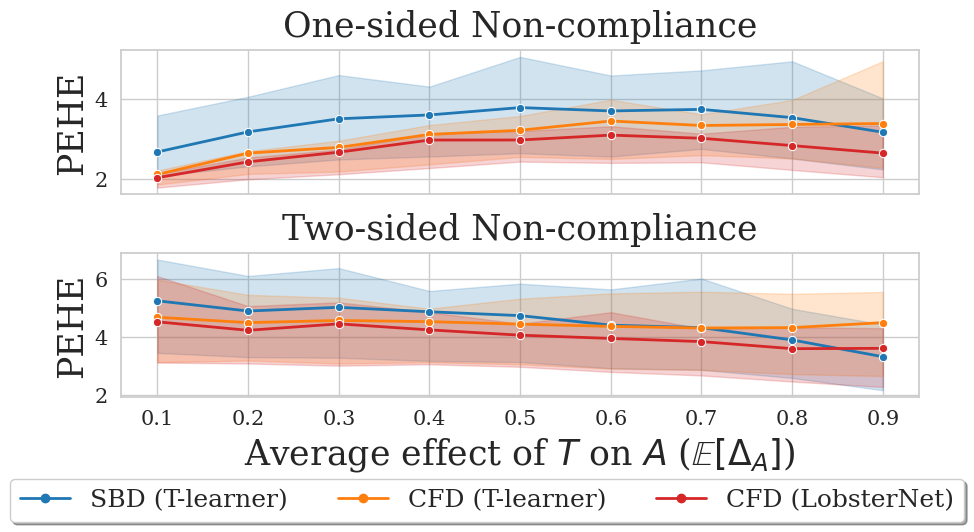

In [7]:
sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
fig, axes = plt.subplots(2, 1, figsize=(10*0.9, 5), sharex="col")
palette = sns.color_palette(['tab:blue', 'tab:orange', 'tab:red'])

plot_ihdp_rate_eval_df = ihdp_rate_eval_df[ihdp_rate_eval_df.model.isin(["SBD (T-learner)", "CFD (T-learner)", "CFD (LobsterNet)"])].copy()
plot_ihdp_rate_eval_df.nc_rate = (plot_ihdp_rate_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_ihdp_rate_eval_df["delta_A"] = plot_ihdp_rate_eval_df["delta_A"].round(decimals=1)
sns.lineplot(data=plot_ihdp_rate_eval_df[(plot_ihdp_rate_eval_df.label=="assign effect PEHE") & (plot_ihdp_rate_eval_df.nc_type=="one-sided")], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[0], errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", 
             markers=["o", "o", "o"], dashes=False, palette=palette)
sns.lineplot(data=plot_ihdp_rate_eval_df[(plot_ihdp_rate_eval_df.label=="assign effect PEHE") & (plot_ihdp_rate_eval_df.nc_type=="two-sided")], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[1], errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", 
             markers=["o", "o", "o"], dashes=False, palette=palette)
for ax in axes:
    ax.get_legend().remove()
axes[1].set_ylabel("PEHE", fontsize=25)
axes[0].set_ylabel("PEHE", fontsize=25)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].set_xlabel(r"Average effect of $T$ on $A$ ($\mathbb{E}[\Delta_A]$)", fontsize=25)
axes[0].set_title(r"One-sided Non-compliance", fontsize=25, pad=10)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=25, pad=10)
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, 
    fancybox=True, shadow=True, fontsize=18)
fig.tight_layout()

In [8]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

for nc_type in ["one-sided", "two-sided"]:
    print(nc_type)
    for method in ihdp_rate_eval_df.model.unique():
        print(f"\t{method}: ", end="")
        mean, ci_pm = mean_confidence_interval(
            ihdp_rate_eval_df[(ihdp_rate_eval_df.nc_type==nc_type) & 
                (ihdp_rate_eval_df.model==method) & (ihdp_rate_eval_df.label=="assign effect PEHE")].value)
        print(f"{mean:.3f} $\pm$ {ci_pm:.3f}")

one-sided
	SBD (T-learner): 3.429 $\pm$ 0.206
	CFD (T-learner): 3.042 $\pm$ 0.163
	CFD (LobsterNet): 2.736 $\pm$ 0.135
two-sided
	SBD (T-learner): 4.530 $\pm$ 0.230
	CFD (T-learner): 4.474 $\pm$ 0.225
	CFD (LobsterNet): 4.064 $\pm$ 0.185
